In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import time
from pathlib import Path
import gc
import torch_pruning as tp
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- Dependency Check for TensorRT ---
try:
    import torch_tensorrt
    TENSORRT_AVAILABLE = True
    print("✓ torch_tensorrt is available. TensorRT models will be benchmarked.")
except ImportError:
    TENSORRT_AVAILABLE = False
    print("⚠️ WARNING: torch_tensorrt is not installed. TensorRT models will be skipped.")

# --- Configuration ---
ROOT_DIR = "saved_models_and_logs"
OUTPUT_CSV_NB = "model_UNIFIED_benchmark.csv"
if not torch.cuda.is_available():
    print("✗ FATAL: CUDA is not available. This script requires a GPU for full functionality.")
    exit()
DEVICE = torch.device("cuda")
print(f"Using device: {DEVICE} ({torch.cuda.get_device_name(0)})")
torch.backends.cudnn.benchmark = True
sns.set_style("whitegrid")

# --- BENCHMARKING Configuration ---
DUMMY_INPUT_SHAPE = (32, 3, 224, 224)
NUM_WARMUP_RUNS = 5
NUM_BENCHMARK_RUNS = 10

# --- Shared Configuration ---
DEFAULT_NUM_CLASSES = 1000
FIXED_NUM_CLASSES = 1000
INPUT_TENSOR_CPU = torch.randn(DUMMY_INPUT_SHAPE)
GPU_UNSTABLE_QUANTIZED_MODELS = [ # Kept for non-TRT quantized models
    "resnet18pretrained_distilled_quant_ptq_int8_perchannel_post",
    "resnet18pretrained_distilled_quant_ptq_int8_pertensor_post",
    "resnet18pretrained_distilled_quant_qat_int8_epochs8",
    "resnet50_quant_ptq_int8_perchannel_post",
    "resnet50_quant_ptq_int8_pertensor_post",
    "resnet50_quant_qat_int8_epochs8",
]

✓ torch_tensorrt is available. TensorRT models will be benchmarked.
Using device: cuda (NVIDIA GeForce RTX 3070 Ti)


In [2]:
# --- Helper: Model File ---
def get_model_file_path_nb(experiment_path_str, file_name):
    return str(Path(experiment_path_str) / file_name)

# --- Model Definition and Pruning Application ---
def get_base_resnet50_model_for_reconstruction_nb():
    return models.resnet50(weights=None, num_classes=FIXED_NUM_CLASSES)

def apply_structured_pruning_to_model_for_reconstruction_nb(model, example_inputs, rate, device_obj):
    model.to(device_obj)
    example_inputs = example_inputs.to(device_obj)
    ignored_layers = [m for m in model.modules() if isinstance(m, nn.Linear) and m.out_features == FIXED_NUM_CLASSES]
    pruner = tp.pruner.MagnitudePruner(
        model=model, example_inputs=example_inputs, importance=tp.importance.MagnitudeImportance(p=1),
        iterative_steps=1, pruning_ratio=rate, global_pruning=False, ignored_layers=ignored_layers
    )
    pruner.step()
    return model

def get_pruning_config_from_log_for_reconstruction_nb(log_file_path_str):
    if not Path(log_file_path_str).exists(): return None
    try:
        with open(log_file_path_str, 'r') as f: log_data = json.load(f)
        cfg = log_data.get('config_details', {})
        if cfg.get('target_filter_pruning_rate_per_layer') is not None:
            return {'type': 'one-shot', 'rate': float(cfg['target_filter_pruning_rate_per_layer'])}
        if cfg.get('applied_step_rate_for_this_stage') is not None:
            return {'type': 'iterative_step', 'rate': float(cfg['applied_step_rate_for_this_stage'])}
    except Exception: return None
    return None

def _reconstruct_model_arch_and_load_weights_nb(model_path, device, pruning_config, exp_id=""):
    if not pruning_config: return None
    reconstructed_model = get_base_resnet50_model_for_reconstruction_nb()
    example_inputs = torch.randn(1, 3, 224, 224, device=device) # small tensor for reconstruction
    try:
        if pruning_config['type'] == 'one-shot':
            reconstructed_model = apply_structured_pruning_to_model_for_reconstruction_nb(reconstructed_model, example_inputs, pruning_config['rate'], device)
        elif pruning_config['type'] == 'iterative':
            for rate in pruning_config.get('step_rates', []):
                reconstructed_model = apply_structured_pruning_to_model_for_reconstruction_nb(reconstructed_model, example_inputs, rate, device)
        else: return None
        if reconstructed_model is None: return None
        
        state_dict = torch.load(model_path, map_location=device, weights_only=True)
        if all(k.startswith('module.') for k in state_dict): state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        reconstructed_model.load_state_dict(state_dict)
        reconstructed_model.eval()
        return reconstructed_model
    except Exception as e:
        print(f"      ERROR in reconstruction for {exp_id}: {e}")
        return None

# --- Central Model Loading Function ---
def load_model_for_experiment_nb(exp_info, all_experiments_df, target_device_str='cpu'):
    model_path = exp_info.get('Model_File_Path')
    exp_id = exp_info.get('Experiment_ID', 'Unknown_Exp')
    if not model_path or not os.path.exists(model_path):
        print(f"      ERROR ({exp_id}): Model file not found at {model_path}")
        return None
    device_to_load_on = torch.device(target_device_str)
    
    # Handle JIT/TensorRT models first
    if exp_info.get('Model_Type') == 'TensorRT':
        try:
            return torch.jit.load(model_path, map_location=device_to_load_on).eval()
        except Exception as e:
            print(f"      ERROR ({exp_id}): JIT/TensorRT loading failed: {e}")
            return None

    if exp_info.get('Is_Structured_Pruning', False):
        # (Rest of the structured pruning logic is complex and kept as is)
        pruning_config = None
        base_exp_name = exp_info.get('Base_Exp_Name_Iterative')
        stage_num = exp_info.get('Stage_Num_Iterative')
        if base_exp_name and stage_num is not None: # Iterative
            stages_info = all_experiments_df[(all_experiments_df['Base_Exp_Name_Iterative'] == base_exp_name) & (all_experiments_df['Stage_Num_Iterative'] <= stage_num)].sort_values(by='Stage_Num_Iterative')
            rates = [get_pruning_config_from_log_for_reconstruction_nb(row.get('Log_Path'))['rate'] for _, row in stages_info.iterrows()]
            if rates: pruning_config = {'type': 'iterative', 'step_rates': rates}
        else: # One-shot
            pruning_config = get_pruning_config_from_log_for_reconstruction_nb(exp_info.get('Log_Path'))
        if pruning_config:
            reconstructed = _reconstruct_model_arch_and_load_weights_nb(model_path, device_to_load_on, pruning_config, exp_id)
            if reconstructed: return reconstructed

    try: # Fallback to standard loading for PyTorch models
        base_arch = exp_info.get('Base_Model_Arch')
        num_classes = exp_info.get('Num_Classes', DEFAULT_NUM_CLASSES)
        if base_arch == "ResNet18": model_instance = models.resnet18(weights=None, num_classes=num_classes)
        elif base_arch == "ResNet50": model_instance = models.resnet50(weights=None, num_classes=num_classes)
        else: return None
        
        state_dict = torch.load(model_path, map_location=device_to_load_on)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict: state_dict = state_dict['model_state_dict']
        if any(k.startswith('module.') for k in state_dict): state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model_instance.load_state_dict(state_dict)
        return model_instance.to(device_to_load_on).eval()
    except Exception as e:
        print(f"      ERROR ({exp_id}): Fallback loading failed: {e}")
        return None

print("--- Core model loading infrastructure is defined ---")

--- Core model loading infrastructure is defined ---


In [3]:
# ===================================================================
#                       CELL 3 (CORRECTED)
# ===================================================================
def discover_all_experiments():
    print(f"\n--- Discovering ALL experiments in: {ROOT_DIR} ---")
    discovered_experiments = []
    
    for cat_name in os.listdir(ROOT_DIR):
        cat_path = os.path.join(ROOT_DIR, cat_name)
        if not os.path.isdir(cat_path): continue

        # Handle baseline directories
        if "baseline" in cat_name:
            # ... (this part is already correct, no change needed) ...
            exp_id = cat_name
            exp_path = cat_path
            try:
                model_file = str(next(Path(exp_path).glob('*final*.pth')))
            except StopIteration:
                print(f"  -> Skipping baseline '{exp_id}', no '*final*.pth' model file found.")
                continue
            base_arch = "ResNet18" if "resnet18" in exp_id else "ResNet50"
            log_path = os.path.join(exp_path, "log.json")
            exp_data = {
                "Experiment_ID": exp_id, "Experiment_Path": exp_path, "Model_File_Path": model_file,
                "Base_Model_Arch": base_arch, "Model_Type": "PyTorch", "Log_Path": log_path,
                "Num_Classes": DEFAULT_NUM_CLASSES, "Is_Structured_Pruning": False,
                "Base_Exp_Name_Iterative": None, "Stage_Num_Iterative": None
            }
            discovered_experiments.append(exp_data)
            continue

        # Handle other categories
        for item_name in os.listdir(cat_path):
            item_path = os.path.join(cat_path, item_name)
            is_dir = os.path.isdir(item_path)
            
            # Handle TensorRT files (.ts)
            if not is_dir and item_name.endswith('.ts'):
                # ... (this part is correct, no change needed) ...
                if not TENSORRT_AVAILABLE: continue
                exp_id = Path(item_name).stem
                base_arch = "ResNet18" if "resnet18" in exp_id else "ResNet50"
                exp_data = {
                    "Experiment_ID": exp_id, "Experiment_Path": cat_path, "Model_File_Path": item_path,
                    "Base_Model_Arch": base_arch, "Model_Type": "TensorRT", "Log_Path": None,
                    "Num_Classes": DEFAULT_NUM_CLASSES, "Is_Structured_Pruning": False,
                    "Base_Exp_Name_Iterative": None, "Stage_Num_Iterative": None
                }
                discovered_experiments.append(exp_data)
                continue

            # Handle PyTorch Models (directories)
            if is_dir:
                exp_id = item_name
                
                # ===================================================================
                #                       ✨ NEW LOGIC IS HERE ✨
                # ===================================================================
                # Default logic: check for resnet18 first, then resnet50
                base_arch = "Unknown"
                if "resnet18" in exp_id.lower():
                    base_arch = "ResNet18"
                elif "resnet50" in exp_id.lower():
                    base_arch = "ResNet50"

                # Override for special cases like "combined_distilled_quantized" which are resnet18
                if cat_name == "combined_distilled_quantized":
                    base_arch = "ResNet18"
                # ===================================================================

                try:
                    model_file = str(next(Path(item_path).glob('*final*.pth')))
                except StopIteration:
                    print(f"  -> Skipping '{exp_id}', no '*final*.pth' model file found.")
                    continue
                log_path = os.path.join(item_path, "log.json")
                is_structured = "pruning_structured" in cat_name
                
                base_exp_name_iter, stage_num_iter = None, None
                if is_structured and ("iterative" in cat_name or "_it_" in exp_id or "_stage" in exp_id):
                    match = re.search(r"(.+?)(?:_|-)(?:stage|s)(\d+)", exp_id.lower())
                    if match: base_exp_name_iter, stage_num_iter = match.group(1), int(match.group(2))

                exp_data = {
                    "Experiment_ID": exp_id, "Experiment_Path": item_path, "Model_File_Path": model_file,
                    "Base_Model_Arch": base_arch, "Model_Type": "PyTorch", "Log_Path": log_path,
                    "Num_Classes": DEFAULT_NUM_CLASSES, "Is_Structured_Pruning": is_structured,
                    "Base_Exp_Name_Iterative": base_exp_name_iter, "Stage_Num_Iterative": stage_num_iter
                }
                discovered_experiments.append(exp_data)

    df = pd.DataFrame(discovered_experiments)
    if not df.empty:
        df['Stage_Num_Iterative'] = pd.to_numeric(df['Stage_Num_Iterative'], errors='coerce')
        df = df.set_index("Experiment_ID", drop=False)
    print(f"--- Discovery finished. Found {len(df)} total experiments. ---")
    return df

# Initialize the global DataFrame
results_df = discover_all_experiments()

# Printing section (no changes needed here)
if not results_df.empty:
    print("\n📋 List of all discovered experiments to be benchmarked:")
    display_columns = ['Experiment_ID', 'Model_Type', 'Base_Model_Arch', 'Model_File_Path']
    display(results_df[display_columns])
else:
    print("\n⚠️ No experiments were discovered. Please check your ROOT_DIR and folder structure.")


--- Discovering ALL experiments in: saved_models_and_logs ---
  -> Skipping '.ipynb_checkpoints', no '*final*.pth' model file found.
--- Discovery finished. Found 29 total experiments. ---

📋 List of all discovered experiments to be benchmarked:


,Experiment_ID,Model_Type,Base_Model_Arch,Model_File_Path
Experiment_ID,,,,
resnet18pretrained_distilled_quant_kmeans_256clusters_post,resnet18pretrained_distilled_quant_kmeans_256c...,PyTorch,ResNet18,saved_models_and_logs/combined_distilled_quant...
resnet18pretrained_distilled_quant_ptq_int8_perchannel_post,resnet18pretrained_distilled_quant_ptq_int8_pe...,PyTorch,ResNet18,saved_models_and_logs/combined_distilled_quant...
resnet18pretrained_distilled_quant_ptq_int8_pertensor_post,resnet18pretrained_distilled_quant_ptq_int8_pe...,PyTorch,ResNet18,saved_models_and_logs/combined_distilled_quant...
resnet18pretrained_distilled_quant_qat_int8_epochs8,resnet18pretrained_distilled_quant_qat_int8_ep...,PyTorch,ResNet18,saved_models_and_logs/combined_distilled_quant...
resnet18_distilled_trt_fp16,resnet18_distilled_trt_fp16,TensorRT,ResNet18,saved_models_and_logs/kd_tensorrt/resnet18_dis...
resnet18_distilled_trt_fp32,resnet18_distilled_trt_fp32,TensorRT,ResNet18,saved_models_and_logs/kd_tensorrt/resnet18_dis...
resnet50_to_resnet18pretrained_kd,resnet50_to_resnet18pretrained_kd,PyTorch,ResNet18,saved_models_and_logs/knowledge_distillation/r...
resnet50_to_resnet18scratch_kd,resnet50_to_resnet18scratch_kd,PyTorch,ResNet18,saved_models_and_logs/knowledge_distillation/r...
resnet50_prune_nm24_ft,resnet50_prune_nm24_ft,PyTorch,ResNet50,saved_models_and_logs/pruning_nm_sparsity/resn...


In [4]:
# ===================================================================
#                      BENCHMARKING UTILITIES
# ===================================================================
def warm_up_model(model, input_tensor, device, num_warmup=NUM_WARMUP_RUNS):
    """Warms up the model for stable performance measurements."""
    model.to(device)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(input_tensor)
        if device.type == 'cuda':
            torch.cuda.synchronize()

def benchmark_gpu(model, input_tensor_cpu, num_runs=NUM_BENCHMARK_RUNS, model_name="Model"):
    """Performs a detailed benchmark on the GPU, returning detailed statistics."""
    print(f"  -> Benchmarking '{model_name}' on GPU...")
    device_obj = torch.device("cuda")
    input_tensor = input_tensor_cpu.clone().to(device_obj)
    model.to(device_obj)

    if 'FP16' in model_name.upper():
        print("     ... converting model and input to FP16.")
        model.half()
        input_tensor = input_tensor.half()

    warm_up_model(model, input_tensor, device_obj)
    torch.cuda.reset_peak_memory_stats(device_obj)
    
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            _ = model(input_tensor)
            end_event.record()
            torch.cuda.synchronize(device_obj)
            times.append(start_event.elapsed_time(end_event)) # in milliseconds
            
    mem_used = torch.cuda.max_memory_allocated(device_obj) / 1024**2
    times_ms = np.array(times)
    stats = {
        'mean_ms': np.mean(times_ms), 
        'std_ms': np.std(times_ms), 
        'median_ms': np.median(times_ms), 
        'throughput_fps': (1000 / np.mean(times_ms)) * input_tensor.shape[0], 
        'memory_mb': mem_used
    }
    return stats

def benchmark_cpu(model, input_tensor_cpu, num_runs=NUM_BENCHMARK_RUNS, model_name="Model"):
    """Performs a detailed benchmark on the CPU, mirroring the GPU function's output."""
    print(f"  -> Benchmarking '{model_name}' on CPU...")
    device_obj = torch.device("cpu")
    model.to(device_obj).float()
    input_tensor = input_tensor_cpu.clone().to(device_obj)

    warm_up_model(model, input_tensor, device_obj)
    
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.perf_counter()
            _ = model(input_tensor)
            end_time = time.perf_counter()
            times.append((end_time - start_time) * 1000) # convert to ms
            
    times_ms = np.array(times)
    stats = {
        'mean_ms': np.mean(times_ms), 
        'std_ms': np.std(times_ms), 
        'median_ms': np.median(times_ms), 
        'throughput_fps': (1000 / np.mean(times_ms)) * input_tensor.shape[0], 
        'memory_mb': "N/A"
    }
    return stats

print("--- Advanced benchmarking utilities are defined ---")

--- Advanced benchmarking utilities are defined ---


In [5]:
if not results_df.empty:
    print(f"\n{'='*20} RUNNING BENCHMARK WITH INPUT SHAPE: {DUMMY_INPUT_SHAPE} {'='*20}")
    all_benchmark_results = []

    for exp_id, row in results_df.iterrows():
        print(f"\n--- Processing: {exp_id} (Type: {row['Model_Type']}) ---")
        
        # --- Smart Benchmarking Logic ---
        model_type = row['Model_Type']
        
        if model_type == 'PyTorch':
            # Run CPU Benchmark for PyTorch models
            try:
                model_cpu = load_model_for_experiment_nb(row, results_df, 'cpu')
                if model_cpu:
                    stats = benchmark_cpu(model_cpu, INPUT_TENSOR_CPU, model_name=exp_id)
                    stats.update({'Experiment_ID': exp_id, 'device': 'CPU'})
                    all_benchmark_results.append(stats)
                    del model_cpu; gc.collect()
            except Exception as e: print(f"     ERROR during CPU benchmark: {e}")

            # Run GPU Benchmark for PyTorch models (with unstable check)
            if exp_id not in GPU_UNSTABLE_QUANTIZED_MODELS:
                try:
                    model_gpu = load_model_for_experiment_nb(row, results_df, 'cuda')
                    if model_gpu:
                        stats = benchmark_gpu(model_gpu, INPUT_TENSOR_CPU, model_name=exp_id)
                        stats.update({'Experiment_ID': exp_id, 'device': 'GPU'})
                        all_benchmark_results.append(stats)
                        del model_gpu; torch.cuda.empty_cache(); gc.collect()
                except Exception as e: print(f"     ERROR during GPU benchmark: {e}")
            else:
                print("  -> Skipping GPU benchmark (known unstable PyTorch model).")

        elif model_type == 'TensorRT':
            print("  -> Skipping CPU benchmark (TensorRT is GPU-only).")
            try:
                model_trt = load_model_for_experiment_nb(row, results_df, 'cuda')
                if model_trt:
                    stats = benchmark_gpu(model_trt, INPUT_TENSOR_CPU, model_name=exp_id)
                    stats.update({'Experiment_ID': exp_id, 'device': 'GPU'})
                    all_benchmark_results.append(stats)
                    del model_trt; torch.cuda.empty_cache(); gc.collect()
            except Exception as e: print(f"     ERROR during TensorRT benchmark: {e}")
            
    final_results_df = pd.DataFrame(all_benchmark_results)
    print("\n--- All Benchmarking Finished ---")
else:
    print("DataFrame is empty. Nothing to benchmark.")
    final_results_df = pd.DataFrame()


==================== RUNNING BENCHMARK WITH INPUT SHAPE: (32, 3, 224, 224) ====================

--- Processing: resnet18pretrained_distilled_quant_kmeans_256clusters_post (Type: PyTorch) ---
  -> Benchmarking 'resnet18pretrained_distilled_quant_kmeans_256clusters_post' on CPU...
  -> Benchmarking 'resnet18pretrained_distilled_quant_kmeans_256clusters_post' on GPU...

--- Processing: resnet18pretrained_distilled_quant_ptq_int8_perchannel_post (Type: PyTorch) ---


/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


      ERROR (resnet18pretrained_distilled_quant_ptq_int8_perchannel_post): Fallback loading failed: 
  -> Skipping GPU benchmark (known unstable PyTorch model).

--- Processing: resnet18pretrained_distilled_quant_ptq_int8_pertensor_post (Type: PyTorch) ---
      ERROR (resnet18pretrained_distilled_quant_ptq_int8_pertensor_post): Fallback loading failed: 
  -> Skipping GPU benchmark (known unstable PyTorch model).

--- Processing: resnet18pretrained_distilled_quant_qat_int8_epochs8 (Type: PyTorch) ---
      ERROR (resnet18pretrained_distilled_quant_qat_int8_epochs8): Fallback loading failed: 
  -> Skipping GPU benchmark (known unstable PyTorch model).

--- Processing: resnet18_distilled_trt_fp16 (Type: TensorRT) ---
  -> Skipping CPU benchmark (TensorRT is GPU-only).
  -> Benchmarking 'resnet18_distilled_trt_fp16' on GPU...
     ... converting model and input to FP16.

--- Processing: resnet18_distilled_trt_fp32 (Type: TensorRT) ---
  -> Skipping CPU benchmark (TensorRT is GPU-only).
  


--- Processing and Finalizing Benchmark Results ---

✅ Clean benchmark results successfully saved to 'model_UNIFIED_benchmark.csv'

--- Final Benchmark Data ---


,Model,Device,Base_Model_Arch,Optimization_Category,Latency (ms),Throughput (FPS),Size (MB),GPU Mem (MB),Full_Model_Name
0,R18-Distill-TRT-FP16,GPU,ResNet18,TensorRT (Distilled),2.487181,12865.972687,31.016091,18.30957,resnet18_distilled_trt_fp16
1,R18-Distill-TRT-FP32,GPU,ResNet18,TensorRT (Distilled),8.545584,3744.624119,96.014504,27.49707,resnet18_distilled_trt_fp32
2,R18-Distill+Quant,GPU,ResNet18,Combined (Distill + Quant),11.463651,2791.431784,44.667328,268.06543,resnet18pretrained_distilled_quant_kmeans_256c...
3,R50>R18-KD-Scratch,GPU,ResNet18,Knowledge Distillation,11.777226,2717.108521,44.670778,268.06543,resnet50_to_resnet18scratch_kd
4,R50>R18-KD-Pre,GPU,ResNet18,Knowledge Distillation,11.950010,2677.822088,44.670778,268.06543,resnet50_to_resnet18pretrained_kd
5,R18-Baseline,GPU,ResNet18,Baseline,12.502323,2559.524268,44.669577,268.06543,resnet18_baseline
6,R50-TRT-FP16,GPU,ResNet50,TensorRT (Baseline),6.525344,4903.956029,67.378737,18.30957,resnet50_trt_fp16
7,R50-P.Struct-IT-sp90,GPU,ResNet50,Pruning (Structured),9.553181,3349.669676,10.211699,423.724121,resnet50_prune_struct_it_l1filter_stage3_appro...
8,R50-P.Struct-OS-fp55,GPU,ResNet50,Pruning (Structured),13.756992,2326.089880,21.860636,372.172363,resnet50_prune_struct_os_l1filter_fp55_ft
9,R50-P.Struct-OS-fp70,GPU,ResNet50,Pruning (Structured),14.299114,2237.900948,10.561075,314.923828,resnet50_prune_struct_os_l1filter_fp70_ft



--- Generating Performance Plots (Segregated by Architecture) ---

--- Generating plots for: GPU / ResNet18 ---


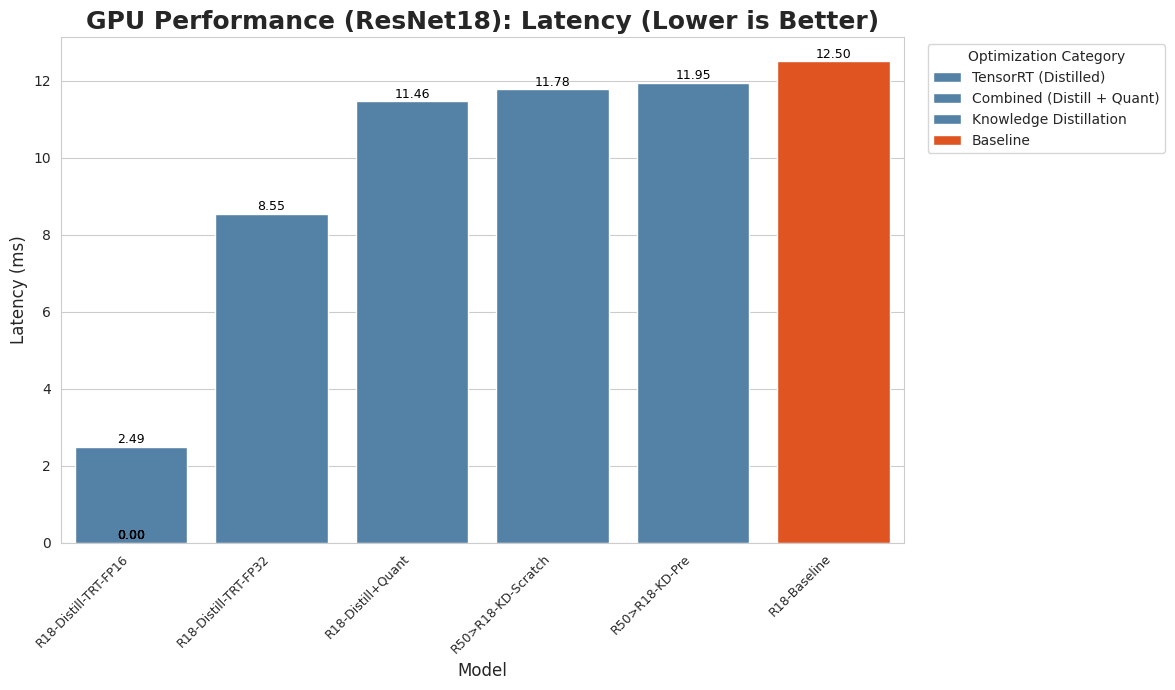

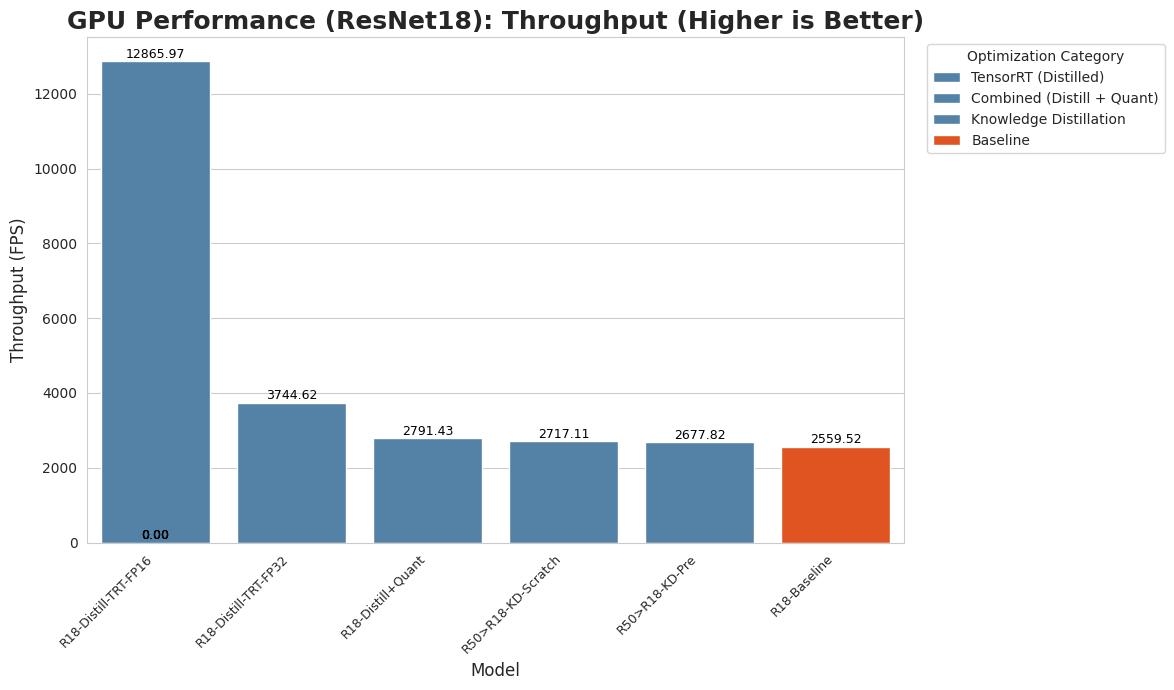


--- Generating plots for: GPU / ResNet50 ---


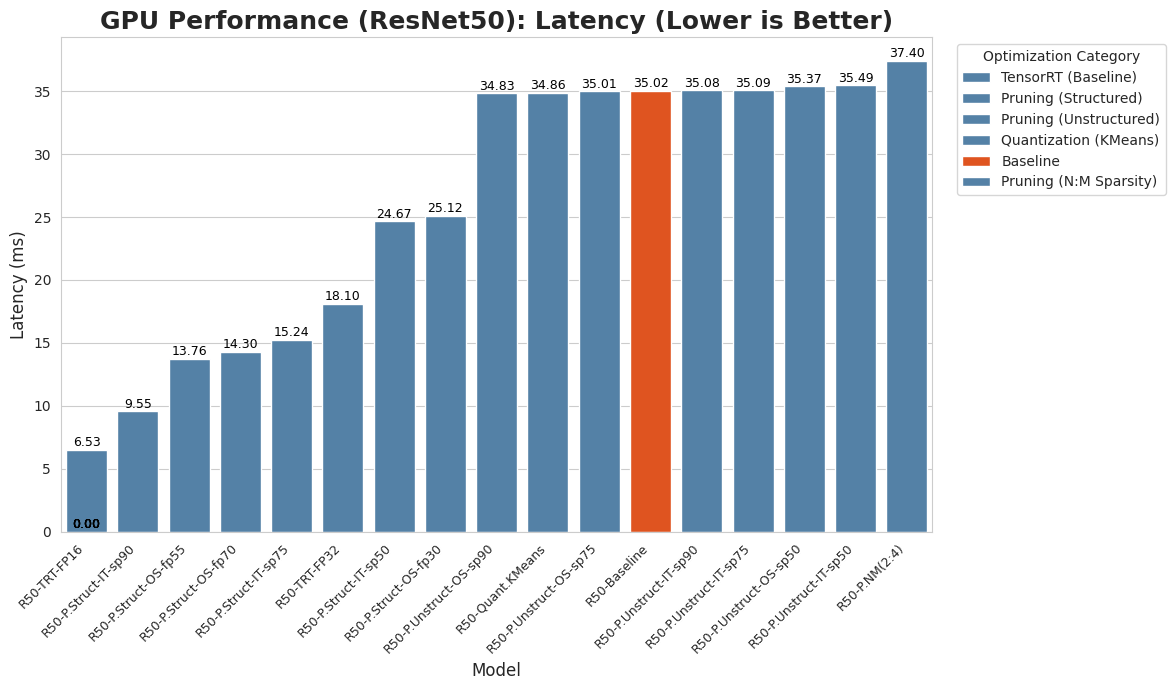

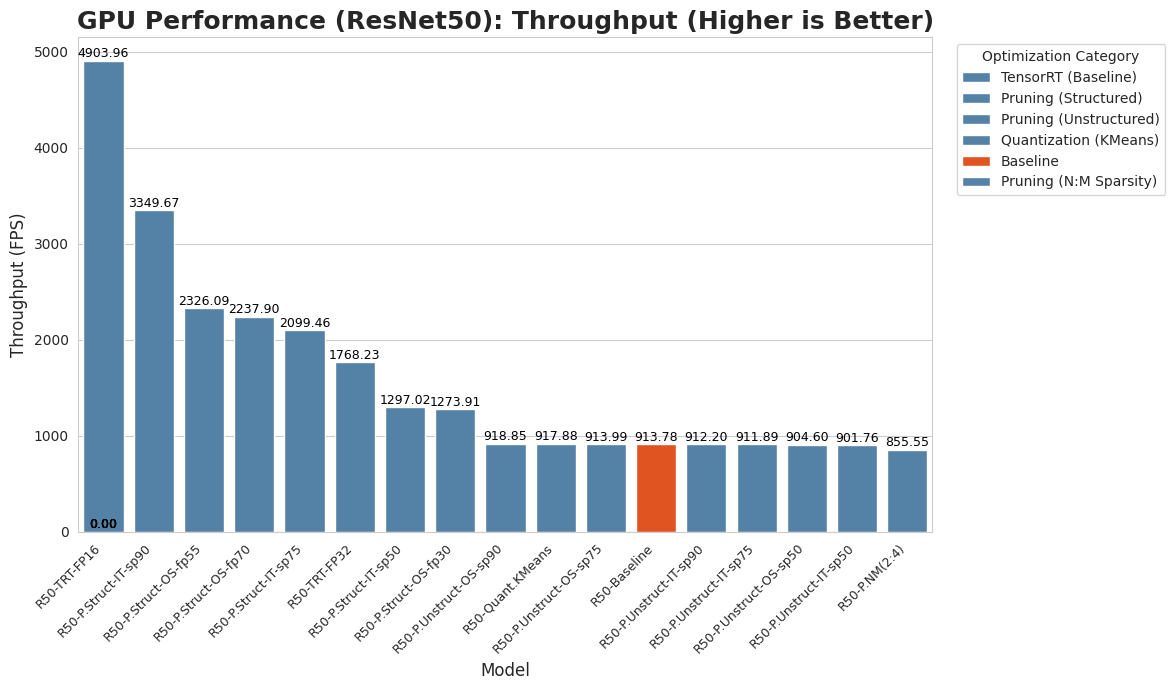


--- Generating plots for: CPU / ResNet18 ---


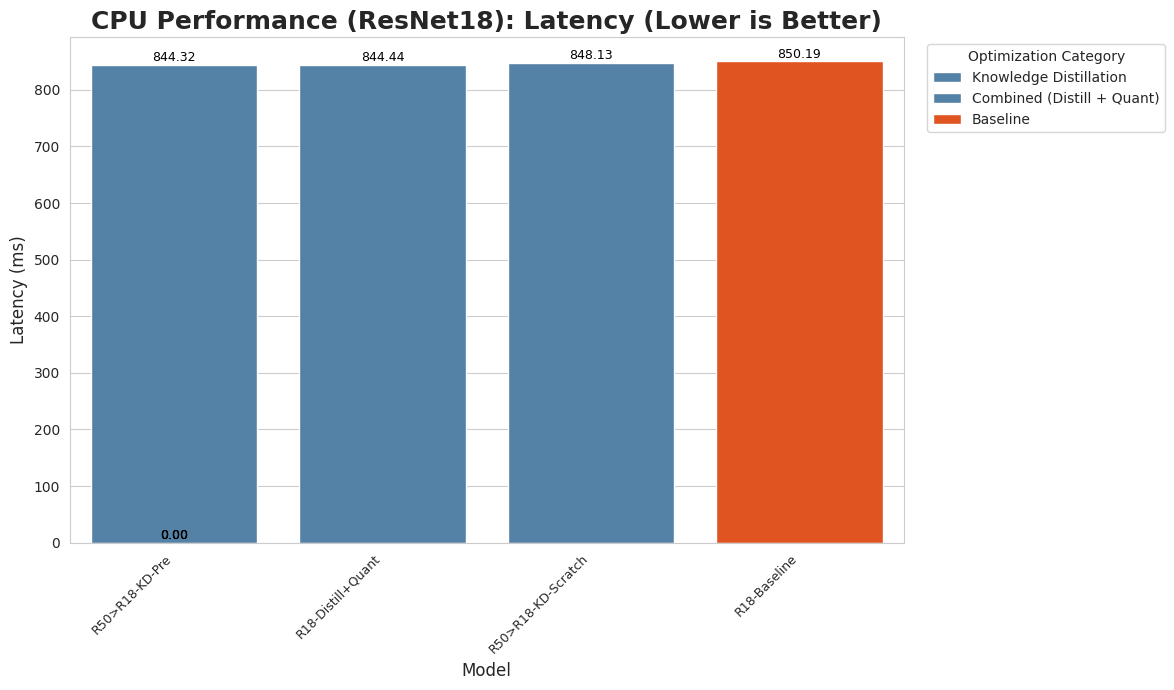

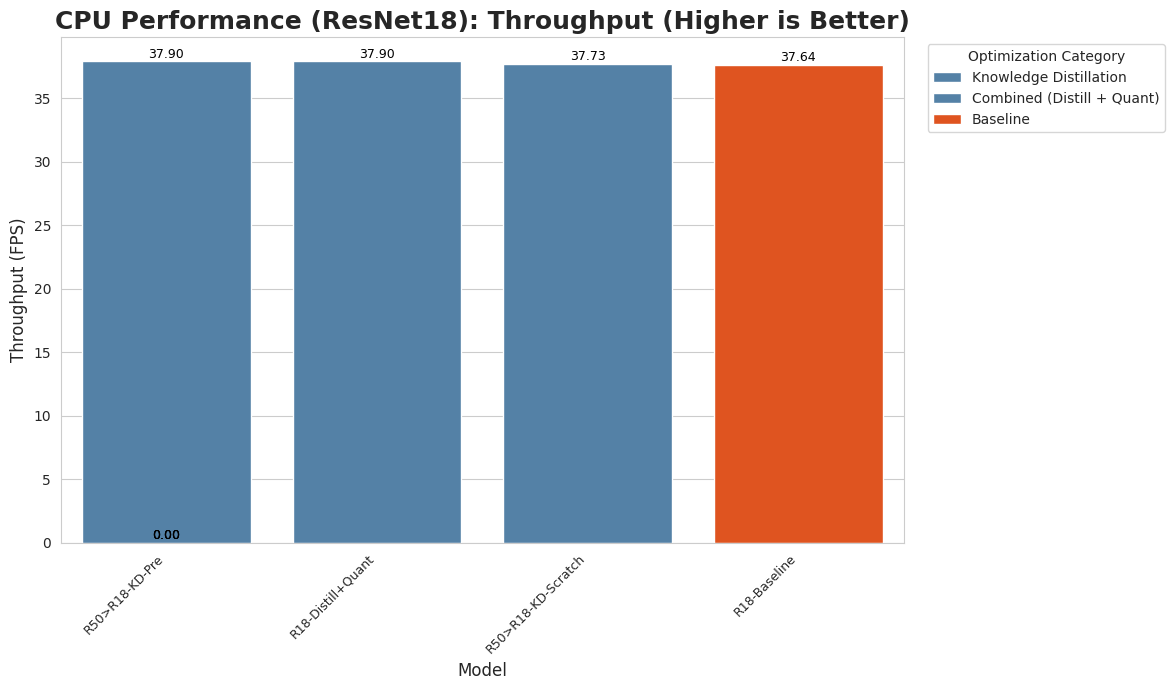


--- Generating plots for: CPU / ResNet50 ---


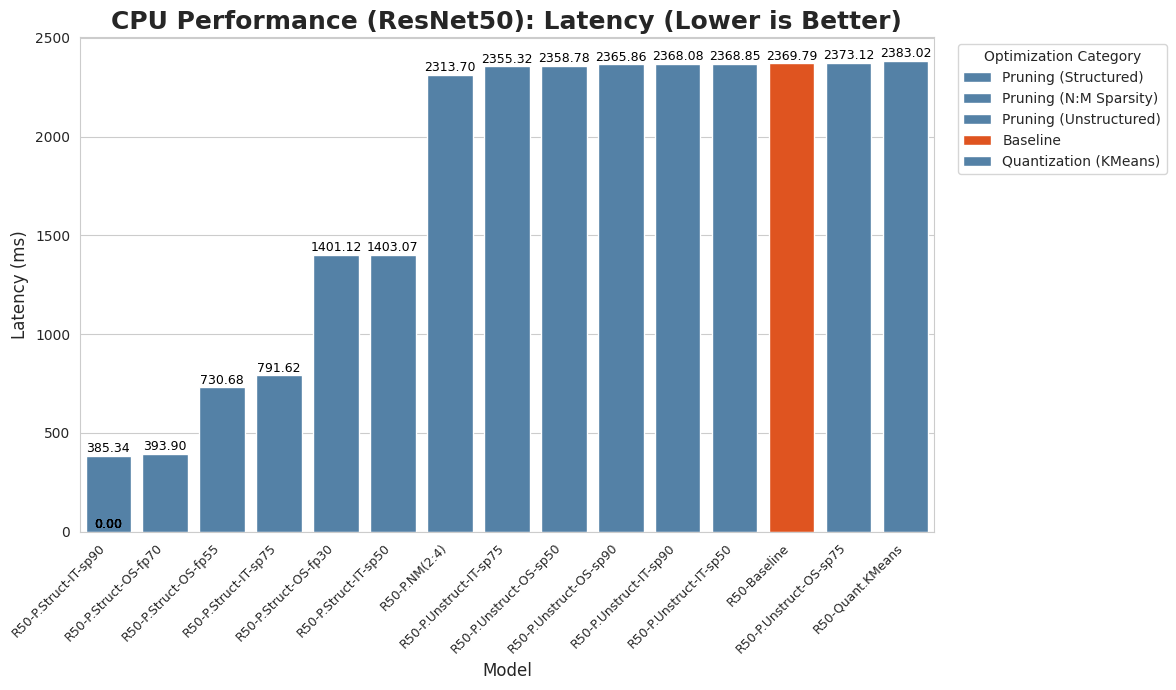

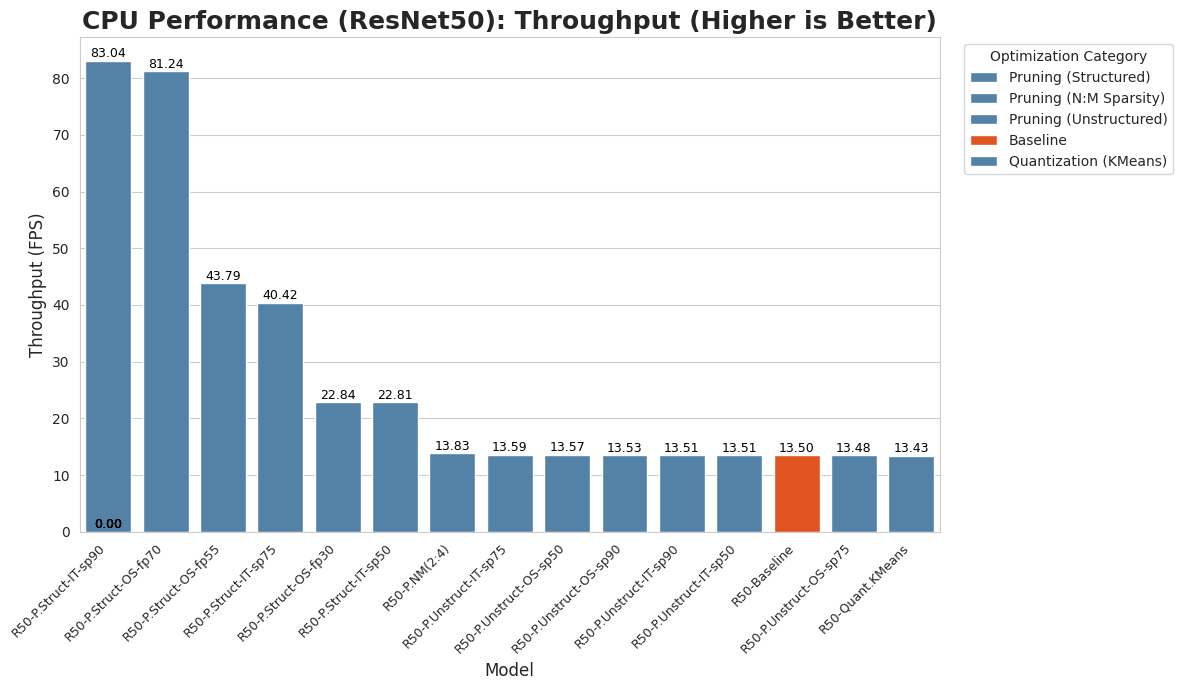

In [26]:
# ===================================================================
#      BLOCK 6: ANALYSIS & VISUALIZATION (Corrected & Polished)
# ===================================================================
import re

if not final_results_df.empty:
    print("\n--- Processing and Finalizing Benchmark Results ---")

    # 1. Merge benchmark results
    full_df = pd.merge(results_df, final_results_df, left_index=True, right_on="Experiment_ID", how="inner")

    # 2. Add Model Size and Optimization Category
    def get_file_size_mb(file_path):
        if file_path and os.path.exists(file_path):
            return os.path.getsize(file_path) / (1024 * 1024)
        return None

    def get_optimization_category(exp_id):
        exp_id = exp_id.lower()
        if 'distilled_trt' in exp_id: return "TensorRT (Distilled)"
        if 'trt' in exp_id: return "TensorRT (Baseline)"
        if 'baseline' in exp_id: return "Baseline"
        if 'kd' in exp_id: return "Knowledge Distillation"
        if 'distilled_quant' in exp_id: return "Combined (Distill + Quant)"
        if 'prune_unstruct' in exp_id: return "Pruning (Unstructured)"
        if 'prune_struct' in exp_id: return "Pruning (Structured)"
        if 'prune_nm24' in exp_id: return "Pruning (N:M Sparsity)"
        if 'quant_kmeans' in exp_id: return "Quantization (KMeans)"
        if 'quant' in exp_id: return "Quantization"
        return "Other"

    full_df['Size (MB)'] = full_df['Model_File_Path'].apply(get_file_size_mb)
    full_df['Optimization_Category'] = full_df['Experiment_ID'].apply(get_optimization_category)

    # ===================================================================
    #           ✨ CORRECTED: Short name generation function ✨
    # ===================================================================
    def generate_short_name(model_name):
        name = model_name.lower()
        # Handle simple cases first
        if name == 'resnet18_baseline': return 'R18-Baseline'
        if name == 'resnet50_baseline': return 'R50-Baseline'
        
        # Define base_arch early so it's available for all conditions
        base_arch = 'R18' if 'resnet18' in name else 'R50'

        # Now handle the complex cases
        if 'trt' in name:
            precision = 'FP16' if 'fp16' in name else 'FP32'
            distill = '-Distill' if 'distilled' in name else ''
            return f'{base_arch}{distill}-TRT-{precision}'
        if 'kd' in name:
            source = 'R50>' if 'resnet50_to' in name else ''
            kd_type = 'Pre' if 'pretrained' in name else 'Scratch'
            return f'{source}{base_arch}-KD-{kd_type}'
        if 'distilled_quant' in name: return 'R18-Distill+Quant' # Hardcoded as per discovery logic
        if 'prune' in name:
            short_name = f'{base_arch}-P'
            if 'unstruct' in name: short_name += '.Unstruct'
            elif 'struct' in name: short_name += '.Struct'
            elif 'nm24' in name: return f'{base_arch}-P.NM(2:4)'
            if '_it_' in name: short_name += '-IT'
            elif '_os_' in name: short_name += '-OS'
            sp_match = re.search(r'sp(\d+)', name)
            fp_match = re.search(r'fp(\d+)', name)
            if sp_match: short_name += f'-sp{sp_match.group(1)}'
            if fp_match: short_name += f'-fp{fp_match.group(1)}'
            return short_name
        if 'quant_kmeans' in name:
            return f'{base_arch}-Quant.KMeans'
        return model_name # Fallback

    # 3. Create the clean 'Model' column and rename original columns
    full_df['Model'] = full_df['Experiment_ID'].apply(generate_short_name)
    full_df.rename(columns={
        'Experiment_ID': 'Full_Model_Name',
        'device': 'Device',
        'mean_ms': 'Latency (ms)',
        'throughput_fps': 'Throughput (FPS)',
        'memory_mb': 'GPU Mem (MB)'
    }, inplace=True)

    # 4. Reorder and select final columns for the CSV
    final_cols = [
        'Model', 'Device', 'Base_Model_Arch', 'Optimization_Category',
        'Latency (ms)', 'Throughput (FPS)', 'Size (MB)', 'GPU Mem (MB)',
        'Full_Model_Name'
    ]
    full_df = full_df[final_cols]
    
    # 5. Sort the DataFrame
    full_df = full_df.sort_values(by=['Device', 'Base_Model_Arch', 'Latency (ms)'], ascending=[False, True, True])
    full_df.reset_index(drop=True, inplace=True)

    # 6. Save the clean CSV and display the DataFrame
    full_df.to_csv(OUTPUT_CSV_NB, index=False)
    print(f"\n✅ Clean benchmark results successfully saved to '{OUTPUT_CSV_NB}'")
    print("\n--- Final Benchmark Data ---")
    display(full_df)

    # 7. Create plots
    print("\n--- Generating Performance Plots (Segregated by Architecture) ---")
    def create_benchmark_plot(plot_data, y_metric, title, is_lower_better=True):
        if plot_data.empty: return
        plt.figure(figsize=(14, 7))
        plot_data = plot_data.sort_values(by=y_metric, ascending=is_lower_better).copy()
        palette = {cat: 'orangered' if cat == 'Baseline' else 'steelblue' for cat in plot_data['Optimization_Category'].unique()}
        ax = sns.barplot(data=plot_data, x='Model', y=y_metric, hue='Optimization_Category', palette=palette, dodge=False)
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')
        plt.title(title, fontsize=18, weight='bold')
        plt.ylabel(y_metric, fontsize=12)
        plt.xlabel('Model', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.legend(title='Optimization Category', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

    for device in full_df['Device'].unique():
        for arch in full_df['Base_Model_Arch'].unique():
            filtered_df = full_df[(full_df['Device'] == device) & (full_df['Base_Model_Arch'] == arch)]
            if filtered_df.empty: continue
            print(f"\n--- Generating plots for: {device} / {arch} ---")
            create_benchmark_plot(filtered_df, 'Latency (ms)', f'{device} Performance ({arch}): Latency (Lower is Better)', True)
            create_benchmark_plot(filtered_df, 'Throughput (FPS)', f'{device} Performance ({arch}): Throughput (Higher is Better)', False)
else:
    print("\n⚠️ Final results DataFrame is empty. No data to process, save, or plot.")